# Laboratorio 2

Autores:

* Kuntur Muenala
* Diego Villacreses

In [65]:
# !pip install skopt
# !pip install scikit-optimize

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
#from skopt import BayesSearchCV
#from skopt.space import Real, Integer
  # Intento fallido de optimización bayesiana sobre hyperparámetros de Naive Bayes

import time
import seaborn as sns

os.chdir("/home/dvillacreses/nlp")
print(f"{os.getcwd()=}")

os.getcwd()='/home/dvillacreses/nlp'


## Load Data

Dataset:
* https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [67]:
# Load from USQF Server
train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

In [68]:
# # Load from Colab
# from google.colab import drive
# drive.mount('/content/drive')
# for root, dirs, files in os.walk('/content/drive/MyDrive/Colab Notebooks/NPL/data'):
#   for file in files:
#     for file in files:
#       path = os.path.join(root, file)
#       if 'train' in path:
#         train_path = path
#       elif 'test' in path:
#         test_path = path
# train_df = pd.read_table(train_path)
# test_df = pd.read_table(test_path)

In [69]:
code_sentiment = {
    0 : 'negative',
    1 : 'somewhat negative',
    2 : 'neutral',
    3 : 'somewhatt positve',
    4 : 'positive'
}

## EDA

In [70]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [71]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [72]:
train_df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [73]:
test_df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        1
dtype: int64

Eliminamos la fila con un valor Nan en la columna `Phrase`

In [74]:
test_df.dropna(inplace=True)

In [75]:
print('Train data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

Train data shape: (156060, 4)
Test data shape: (66291, 3)


### Data Visualization

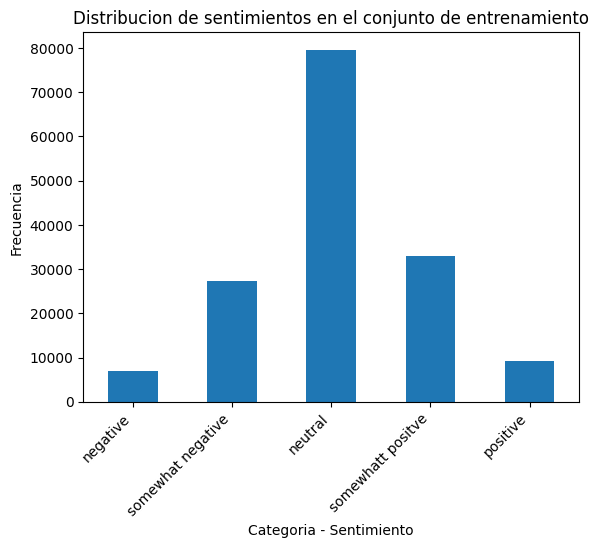

In [76]:
train_df.groupby('Sentiment').size().plot(kind='bar', x='Sentiment')
plt.xticks(ticks=range(len(code_sentiment)), labels=list(code_sentiment.values()), rotation=45, ha='right')
plt.ylabel('Frecuencia')
plt.xlabel('Categoria - Sentimiento')
plt.title('Distribucion de sentimientos en el conjunto de entrenamiento')
plt.show()


Generamos nuevas columnas que midan el numero de palabras en `Prhase` y la longuitud de cada `Prhase`

In [77]:
train_df['word_Count'] = train_df['Phrase'].apply(lambda x: len(x.split()))
train_df['length'] = train_df['Phrase'].apply(lambda x: len(x.strip()))
test_df['word_Count'] = test_df['Phrase'].apply(lambda x: len(x.split()))
test_df['length'] = test_df['Phrase'].apply(lambda x: len(x.strip()))

In [78]:
train_df.describe()

,PhraseId,SentenceId,Sentiment,word_Count,length
count,156060.000000,156060.000000,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578,7.203364,40.217218
std,45050.785842,2502.764394,0.893832,7.024604,38.154137
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,39015.750000,1861.750000,2.000000,2.000000,14.000000
50%,78030.500000,4017.000000,2.000000,5.000000,26.000000
75%,117045.250000,6244.000000,3.000000,10.000000,53.000000
max,156060.000000,8544.000000,4.000000,52.000000,283.000000


In [79]:
test_df.describe()

,PhraseId,SentenceId,word_Count,length
count,66291.000000,66291.000000,66291.000000,66291.000000
mean,189206.765896,10114.922750,6.678674,37.267186
std,19137.018245,966.788752,6.773742,36.555205
min,156061.000000,8545.000000,0.000000,0.000000
25%,172634.500000,9266.000000,2.000000,12.000000
50%,189207.000000,10086.000000,4.000000,23.000000
75%,205779.500000,10941.000000,9.000000,49.000000
max,222352.000000,11855.000000,56.000000,256.000000


En la descripcion de `word_Count` y `length` se encontro frases con celdas vacias o con espacios unicos, por lo que se eliminaran esos caso tanto para el train y test dataset.

In [80]:
train_df[train_df['length'] == 0]

,PhraseId,SentenceId,Phrase,Sentiment,word_Count,length
2005,2006,76,,1,0,0


In [81]:
train_df= train_df[train_df['length'] != 0]

In [82]:
test_df[test_df['length'] == 0]

,PhraseId,SentenceId,Phrase,word_Count,length
1390,157451,8588,,0,0


In [83]:
test_df= test_df[test_df['length'] != 0]

Realizaremos graficas de las nuevas variables para ver el comportamiento de la variable `Phrase`

#### Train Set

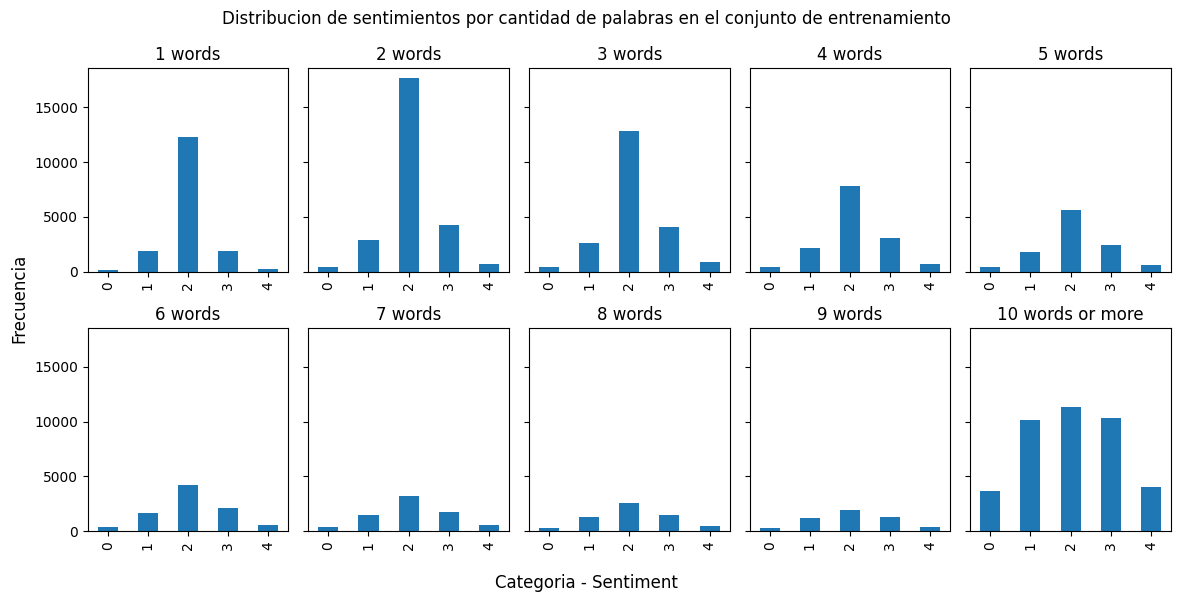

In [84]:
fig, axs = plt.subplots(2,5, figsize=(12, 6), sharey=True)
axs = axs.flatten()
for i in range(10):
    if i != 9:
        train_df[train_df['word_Count'] == i+1].groupby('Sentiment').size().plot(kind='bar', x='Sentiment', ax=axs[i])
        axs[i].set_title(f'{i+1} words')
    else:
        axs[i].set_title(f'{i+1} words or more')
        train_df[train_df['word_Count'] >= i+1].groupby('Sentiment').size().plot(kind='bar', x='Sentiment', ax=axs[i])
    axs[i].set_xlabel('')
fig.suptitle('Distribucion de sentimientos por cantidad de palabras en el conjunto de entrenamiento')
fig.supxlabel('Categoria - Sentiment')
fig.supylabel('Frecuencia')
plt.tight_layout()
plt.show()

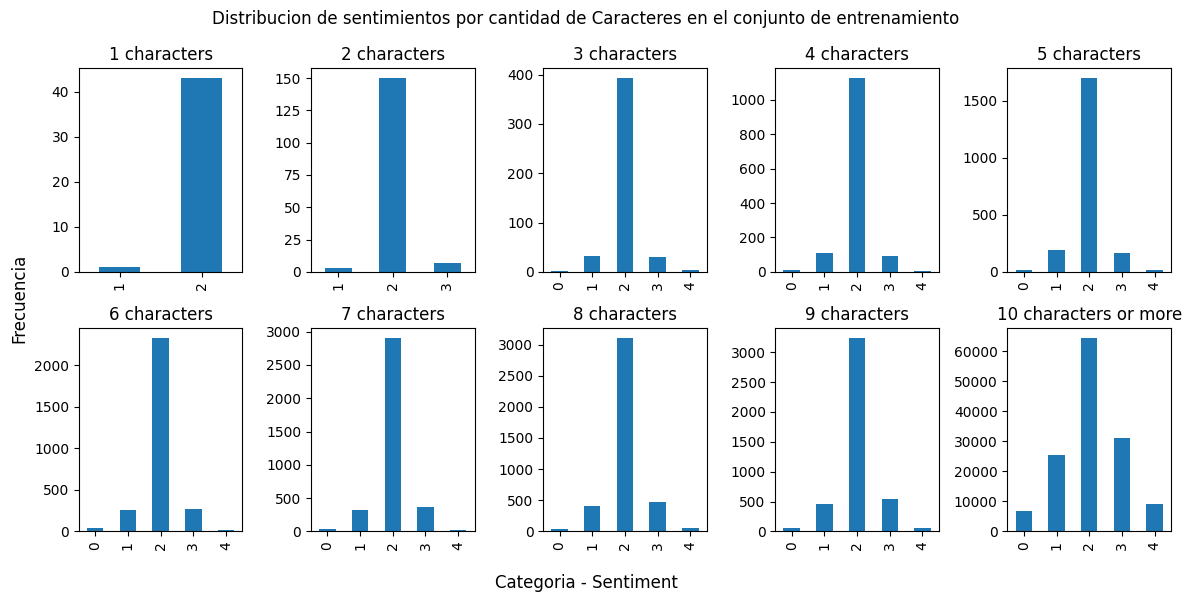

In [85]:
fig, axs = plt.subplots(2,5, figsize=(12, 6))
axs = axs.flatten()
for i in range(10):
    if i != 9:
        train_df[train_df['length'] == i+1].groupby('Sentiment').size().plot(kind='bar', x='Sentiment', ax=axs[i])
        axs[i].set_title(f'{i+1} characters')
    else:
        # pass
        train_df[train_df['length'] >= i+1].groupby('Sentiment').size().plot(kind='bar', x='Sentiment', ax=axs[i])
        axs[i].set_title(f'{i+1} characters or more')
    axs[i].set_xlabel('')
fig.suptitle('Distribucion de sentimientos por cantidad de Caracteres en el conjunto de entrenamiento')
fig.supxlabel('Categoria - Sentiment')
fig.supylabel('Frecuencia')
plt.tight_layout()
plt.show()

#### Test Set

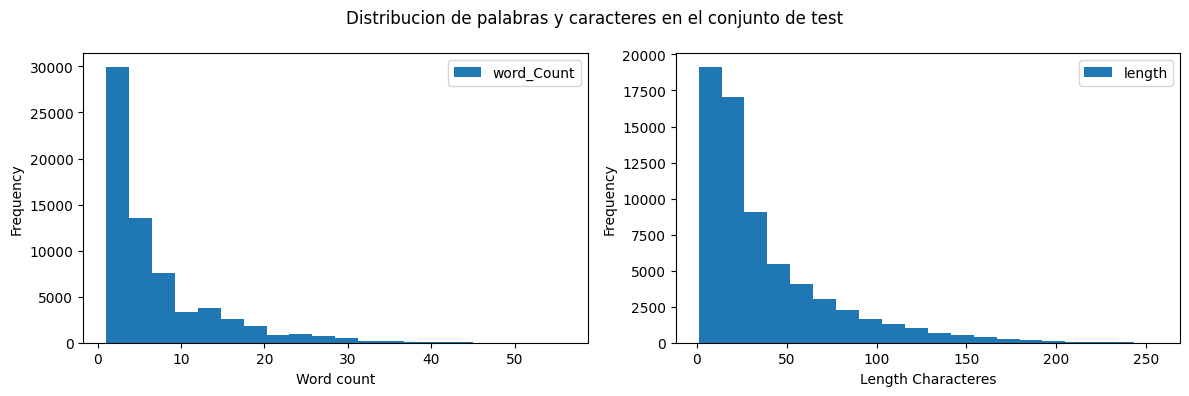

In [86]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
test_df.plot(kind='hist', y='word_Count', bins=20, ax= axs[0])
axs[0].set_xlabel('Word count')


test_df.plot(kind='hist', y='length', bins=20, ax= axs[1])
axs[1].set_xlabel('Length Characteres')
fig.suptitle('Distribucion de palabras y caracteres en el conjunto de test')
plt.tight_layout()
plt.show()

La mayoria de valores en la variables `Phrase` tienen pocas palabras y su longuitud definida como el numero de caracteres tambien es pequeño, por lo tanto eliminaremos las filas de hasta 2 de longuitud, debido a que estas variables no aportan para el analisis de sentimientos, de longuitud 3 en adelante pueden ser adjetivos pequeños que aporten al analisis de sentimientos, de igual forma en el ocnteo de palabras, si bien existe mayores observaciones con 1 o 2 palabras, estas pueden ser adjetivos que aporten al analisis de sentimientos, por lo tanto solo filtraremos con la variables `length`.

In [87]:
train_df[train_df['length'].isin([1,2])].head(5)

,PhraseId,SentenceId,Phrase,Sentiment,word_Count,length
3,4,1,A,2,1,1
6,7,1,of,2,1,2
20,21,1,is,2,1,2
37,38,1,",",2,1,1
56,57,1,to,2,1,2


In [88]:
test_df[test_df['length'].isin([1,2])].head(5)

,PhraseId,SentenceId,Phrase,word_Count,length
2,156063,8545,An,1,2
14,156075,8545,.,1,1
20,156081,8546,is,1,2
34,156095,8546,'s,1,2
40,156101,8546,in,1,2


In [89]:
train_df= train_df[~train_df['length'].isin([1,2])]
test_df= test_df[~test_df['length'].isin([1,2])]

In [90]:
print('Train data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

Train data shape: (155855, 6)
Test data shape: (66157, 5)


In [91]:
# For computational reasons we use only 30% of the data
train_df = train_df.sample(frac=0.6, random_state=42).reset_index(drop=True)

## 2. Tokenizer

In [92]:
reviews_train = ' '.join(train_df['Phrase'])
token_sequence= reviews_train.split()
vocab = sorted(set(sorted(token_sequence)))

In [93]:
total_tokens = {'pp0':len(token_sequence)}
vocab_sizes = {'pp0' : len(vocab)}

In [94]:
print(f'total_tokens= {total_tokens["pp0"]},', f'vocab_sizes= {vocab_sizes["pp0"]}')

total_tokens= 676776, vocab_sizes= 18087


## 3. Bag of words

In [95]:
from collections import Counter

corpus = []
for i, sent in enumerate(train_df['Phrase']):
  conteo = Counter(sent.split())
  for clave in conteo:
    conteo[clave] = 1
  corpus.append(conteo)
df = pd.DataFrame(corpus).fillna(0).astype(int)

In [96]:
df = df.reindex(sorted(df.columns), axis=1)

In [97]:
df.shape

(93513, 18087)

In [98]:
df.head()

,!,!?,#,$,&,','','30s,'40s,'50s,...,zingers,zings,zip,zippy,zips,zombie,zombie-land,zone,zoning,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Define Probability

Probabilidad de cada clase como se muestra a continuacion:

In [99]:
(train_df['Sentiment'].value_counts()/len(train_df['Sentiment'])).sort_index().rename(index=code_sentiment)

Sentiment
negative             0.045716
somewhat negative    0.174254
neutral              0.508485
somewhatt positve    0.211960
positive             0.059585
Name: count, dtype: float64

## 5. Train and evaluate the model

In [100]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 18087) (74810,)
shape: (18703, 18087) (18703,)


In [101]:
mnb= MultinomialNB()

In [102]:
start_time = time.time()
mnb.fit(X_train, y_train)
end_time = time.time()
time_nb = end_time - start_time

In [103]:
models_time = {
    'pp0': time_nb
}

In [104]:
y_pred = mnb.predict(X_eval)

models_acuracy = {'pp0':accuracy_score(y_eval, y_pred)}
models_f1score = {'pp0':f1_score(y_eval, y_pred, average='weighted')}
print("Precisión en el conjunto de prueba:", models_acuracy['pp0'])
print("F1-Score (weighted):", models_f1score['pp0'])

Precisión en el conjunto de prueba: 0.5942362187884297
F1-Score (weighted): 0.5853228194020819


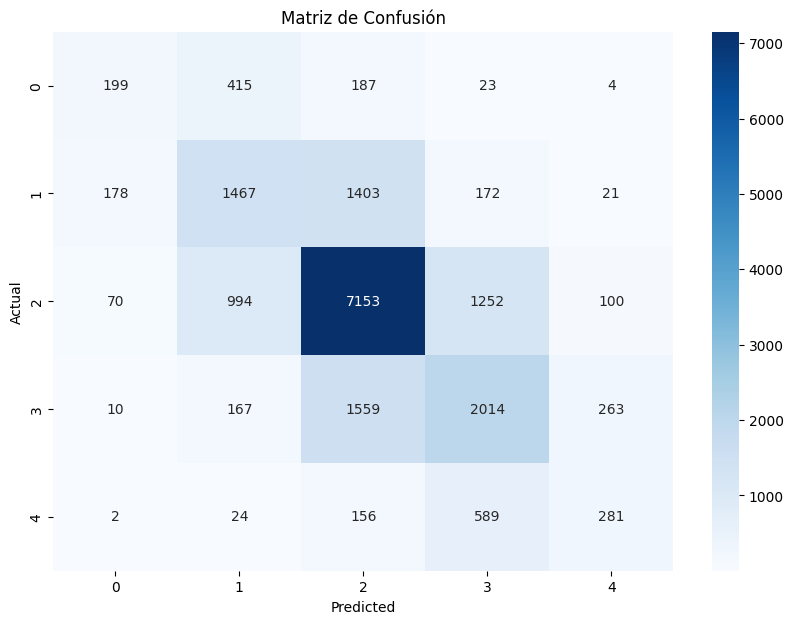

In [105]:
cm = confusion_matrix(y_eval, y_pred)

# Mostrar la matriz de confusión usando seaborn para una mejor visualización
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [106]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.43      0.24      0.31       828
           1       0.48      0.45      0.47      3241
           2       0.68      0.75      0.71      9569
           3       0.50      0.50      0.50      4013
           4       0.42      0.27      0.33      1052

    accuracy                           0.59     18703
   macro avg       0.50      0.44      0.46     18703
weighted avg       0.58      0.59      0.59     18703



## 6. Make Adjustments BoW

Para un mejor analisis se realizara varios casos de estudio, donde se implenete cada una de las tecnicas que ajustan al BoW. estos casos de estudio son:

- Caso 0:
  - sin preprocesamiento
  
- Caso 1
  - Case folding

- Caso 2
  - Case folding
  - Remove stop words

- Caso 3
  - Case folding
  - Remove stop words
  - stemming

- Caso 4
  - Case folding
  - Remove stop words
  - stemming
  - lemmatization

- Caso 5
  - Case folding
  - Remove stop words
  - stemming
  - lemmatization
  - remover caracteres especiales y numeros

- Caso 6
  - Case folding
  - Remove stop words
  - stemming
  - lemmatization
  - remover caracteres especiales y numeros.
  - instead of using a 0/1 (binary) vector, use the number of times that a word occurs in the text.


In [107]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text1(text):
    tokens = nltk.word_tokenize(text.lower())  # Case folding
    return ' '.join(tokens)

def preprocess_text2(text):
    tokens = nltk.word_tokenize(text.lower())  # Case folding
    tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

def preprocess_text3(text):
    tokens = nltk.word_tokenize(text.lower())  # Case folding
    tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    return ' '.join(tokens)

def preprocess_text4(text):
    tokens = nltk.word_tokenize(text.lower())  # Case folding
    tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    return ' '.join(tokens)

def preprocess_text5(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Elimina caracteres especiales y numeros
    tokens = nltk.word_tokenize(text.lower())  # Case folding
    tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Caso 1:
El ajuste de BoW se realiza con las tecnicas:
- Case folding

In [108]:
train_df['phrase_processed1'] = train_df['Phrase'].apply(preprocess_text1)

reviews_train = ' '.join(train_df['phrase_processed1'])
token_pp_sequence= reviews_train.split()
vocab_pp_word = sorted(set(sorted(token_pp_sequence)))

total_tokens['pp1'] = len(token_pp_sequence)
vocab_sizes['pp1'] = len(vocab_pp_word)

print(f"total_tokens= {total_tokens['pp1']},", f"vocab_sizes= {vocab_sizes['pp1']}")

total_tokens= 677364, vocab_sizes= 16465


In [109]:
import gc

del df, corpus, X_train, X_eval, y_train, y_eval

gc.collect()

7107

In [110]:
corpus = []
for i, sent in enumerate(train_df['phrase_processed1']):
  conteo = Counter(sent.split())
  for clave in conteo:
    conteo[clave] = 1
  corpus.append(conteo)

df = pd.DataFrame(corpus).fillna(0).astype(int)

df = df.reindex(sorted(df.columns), axis=1)
df.head()

,!,#,$,&,','','30s,'40s,'50s,'53,...,zoe,zombie,zombie-land,zone,zoning,zoolander,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 16465) (74810,)
shape: (18703, 16465) (18703,)


In [112]:
mnb_pp1= MultinomialNB()

start_time = time.time()
mnb_pp1.fit(X_train, y_train)
end_time = time.time()
models_time['pp1'] = end_time - start_time

In [113]:
y_pred = mnb_pp1.predict(X_eval)

models_acuracy['pp1']= accuracy_score(y_eval, y_pred)
models_f1score['pp1']= f1_score(y_eval, y_pred, average='weighted')
print("Precisión en el conjunto de prueba:", models_acuracy['pp1'])
print("F1-Score (weighted):", models_f1score['pp1'])

Precisión en el conjunto de prueba: 0.5942362187884297
F1-Score (weighted): 0.5843471274685119


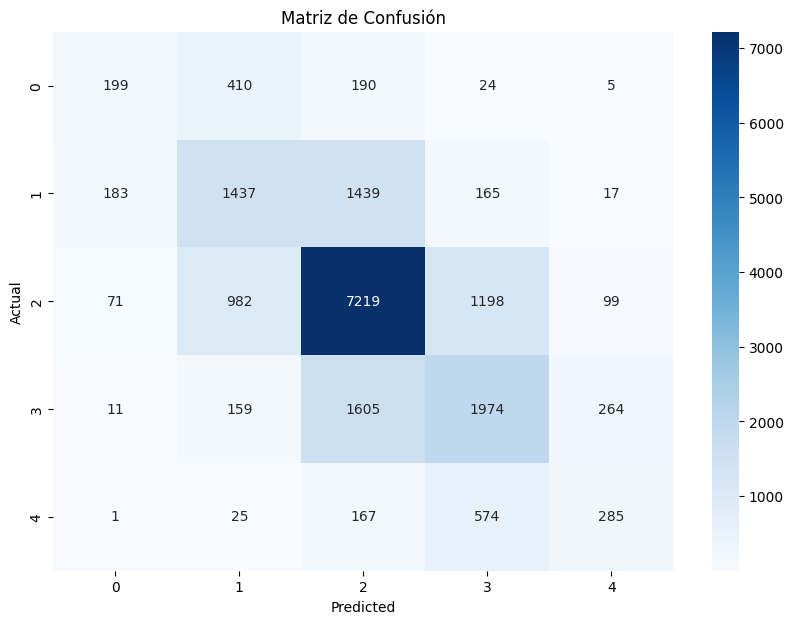

In [114]:
cm = confusion_matrix(y_eval, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [115]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.43      0.24      0.31       828
           1       0.48      0.44      0.46      3241
           2       0.68      0.75      0.72      9569
           3       0.50      0.49      0.50      4013
           4       0.43      0.27      0.33      1052

    accuracy                           0.59     18703
   macro avg       0.50      0.44      0.46     18703
weighted avg       0.58      0.59      0.58     18703



### Caso 2:
El ajuste de BoW se realiza con las tecnicas:
- Case folding
- remove stop words


In [116]:
train_df['phrase_processed2'] = train_df['Phrase'].apply(preprocess_text2)

reviews_train = ' '.join(train_df['phrase_processed2'])
token_pp_sequence= reviews_train.split()
vocab_pp_word = sorted(set(sorted(token_pp_sequence)))

total_tokens['pp2'] = len(token_pp_sequence)
vocab_sizes['pp2'] = len(vocab_pp_word)

print(f"total_tokens= {total_tokens['pp2']},", f"vocab_sizes= {vocab_sizes['pp2']}")

total_tokens= 428043, vocab_sizes= 16334


In [117]:
del df, corpus, X_train, X_eval, y_train, y_eval

gc.collect()

7097

In [118]:
corpus = []
for i, sent in enumerate(train_df['phrase_processed2']):
  conteo = Counter(sent.split())
  for clave in conteo:
    conteo[clave] = 1
  corpus.append(conteo)

df = pd.DataFrame(corpus).fillna(0).astype(int)

df = df.reindex(sorted(df.columns), axis=1)
df.head()

,!,#,$,&,','','30s,'40s,'50s,'53,...,zoe,zombie,zombie-land,zone,zoning,zoolander,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 16334) (74810,)
shape: (18703, 16334) (18703,)


In [120]:
mnb_pp2= MultinomialNB()

start_time = time.time()
mnb_pp2.fit(X_train, y_train)
end_time = time.time()
models_time['pp2'] = end_time - start_time

In [121]:
y_pred = mnb_pp2.predict(X_eval)

models_acuracy['pp2']= accuracy_score(y_eval, y_pred)
models_f1score['pp2']= f1_score(y_eval, y_pred, average='weighted')
print("Precisión en el conjunto de prueba:", models_acuracy['pp2'])
print("F1-Score (weighted):", models_f1score['pp2'])

Precisión en el conjunto de prueba: 0.5915628508795381
F1-Score (weighted): 0.5798888824826814


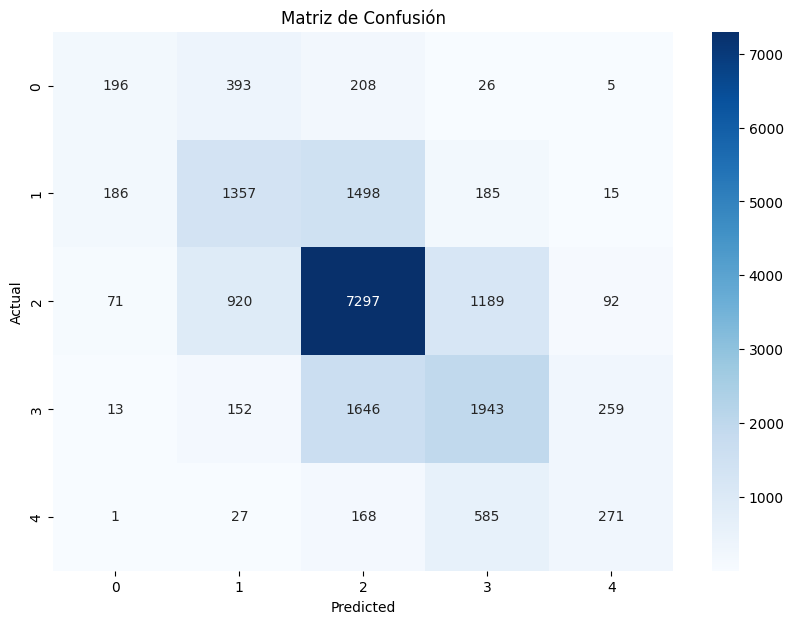

In [122]:
cm = confusion_matrix(y_eval, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [123]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.42      0.24      0.30       828
           1       0.48      0.42      0.45      3241
           2       0.67      0.76      0.72      9569
           3       0.49      0.48      0.49      4013
           4       0.42      0.26      0.32      1052

    accuracy                           0.59     18703
   macro avg       0.50      0.43      0.45     18703
weighted avg       0.58      0.59      0.58     18703



### Caso 3:
El ajuste de BoW se realiza con las tecnicas:
- Case folding
- remove stop words
- stemming

In [124]:
train_df['phrase_processed3'] = train_df['Phrase'].apply(preprocess_text3)

reviews_train = ' '.join(train_df['phrase_processed3'])
token_pp_sequence= reviews_train.split()
vocab_pp_word = sorted(set(sorted(token_pp_sequence)))

total_tokens['pp3'] = len(token_pp_sequence)
vocab_sizes['pp3'] = len(vocab_pp_word)

print(f"total_tokens= {total_tokens['pp3']},", f"vocab_sizes= {vocab_sizes['pp3']}")

total_tokens= 428043, vocab_sizes= 11973


In [125]:
del df, corpus, X_train, X_eval, y_train, y_eval

gc.collect()

7097

In [126]:
corpus = []
for i, sent in enumerate(train_df['phrase_processed3']):
  conteo = Counter(sent.split())
  for clave in conteo:
    conteo[clave] = 1
  corpus.append(conteo)

df = pd.DataFrame(corpus).fillna(0).astype(int)

df = df.reindex(sorted(df.columns), axis=1)
df.head()

,!,#,$,&,','','30,'40,'50,'53,...,ziyi,zoe,zombi,zombie-land,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 11973) (74810,)
shape: (18703, 11973) (18703,)


In [128]:
mnb_pp3= MultinomialNB()

start_time = time.time()
mnb_pp3.fit(X_train, y_train)
end_time = time.time()
models_time['pp3'] = end_time - start_time

In [129]:
y_pred = mnb_pp3.predict(X_eval)

models_acuracy['pp3']=accuracy_score(y_eval, y_pred)
models_f1score['pp3']=f1_score(y_eval, y_pred, average='weighted')
print("Precisión en el conjunto de prueba:", models_acuracy['pp3'])
print("F1-Score (weighted):", models_f1score['pp3'])

Precisión en el conjunto de prueba: 0.5948243597283858
F1-Score (weighted): 0.5786517015178004


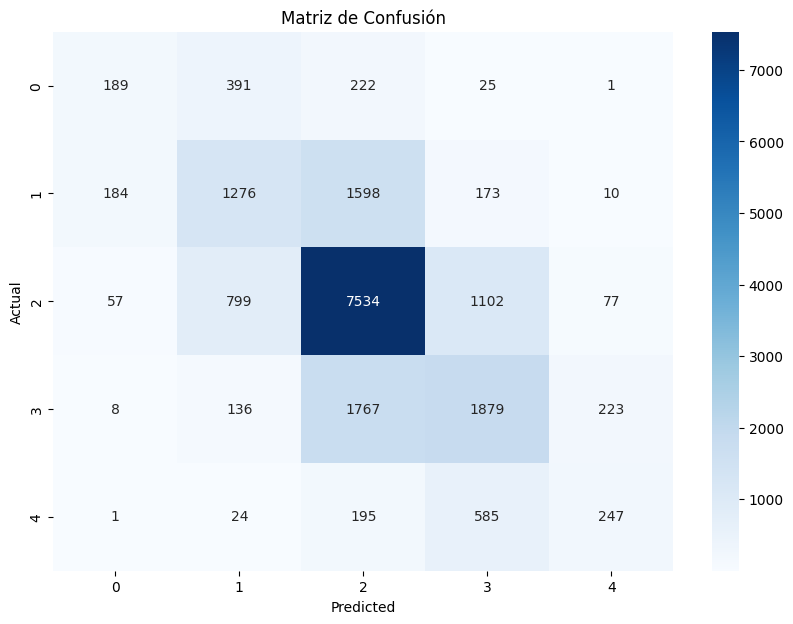

In [130]:
cm = confusion_matrix(y_eval, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [131]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.43      0.23      0.30       828
           1       0.49      0.39      0.43      3241
           2       0.67      0.79      0.72      9569
           3       0.50      0.47      0.48      4013
           4       0.44      0.23      0.31      1052

    accuracy                           0.59     18703
   macro avg       0.50      0.42      0.45     18703
weighted avg       0.58      0.59      0.58     18703



### Caso 4:
El ajuste de BoW se realiza con las tecnicas:
- Case folding
- remove stop words
- stemming
- lemmatization

In [132]:
train_df['phrase_processed4'] = train_df['Phrase'].apply(preprocess_text4)

reviews_train = ' '.join(train_df['phrase_processed4'])
token_pp_sequence= reviews_train.split()
vocab_pp_word = sorted(set(sorted(token_pp_sequence)))

total_tokens['pp4'] = len(token_pp_sequence)
vocab_sizes['pp4'] = len(vocab_pp_word)

print(f"total_tokens= {total_tokens['pp4']},", f"vocab_sizes= {vocab_sizes['pp4']}")

total_tokens= 428043, vocab_sizes= 11953


In [133]:
del df, corpus, X_train, X_eval, y_train, y_eval

gc.collect()

7

In [134]:
corpus = []
for i, sent in enumerate(train_df['phrase_processed4']):
  conteo = Counter(sent.split())
  for clave in conteo:
    conteo[clave] = 1
  corpus.append(conteo)

df = pd.DataFrame(corpus).fillna(0).astype(int)

df = df.reindex(sorted(df.columns), axis=1)
df.head()

,!,#,$,&,','','30,'40,'50,'53,...,ziyi,zoe,zombi,zombie-land,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 11953) (74810,)
shape: (18703, 11953) (18703,)


In [136]:
mnb_pp4= MultinomialNB()

start_time = time.time()
mnb_pp4.fit(X_train, y_train)
end_time = time.time()
models_time['pp4'] = end_time - start_time

In [137]:
y_pred = mnb_pp4.predict(X_eval)

models_acuracy['pp4']=accuracy_score(y_eval, y_pred)
models_f1score['pp4']=f1_score(y_eval, y_pred, average='weighted')
print("Precisión en el conjunto de prueba:", models_acuracy['pp4'])
print("F1-Score (weighted):", models_f1score['pp4'])

Precisión en el conjunto de prueba: 0.5947174250120302
F1-Score (weighted): 0.5784758702678964


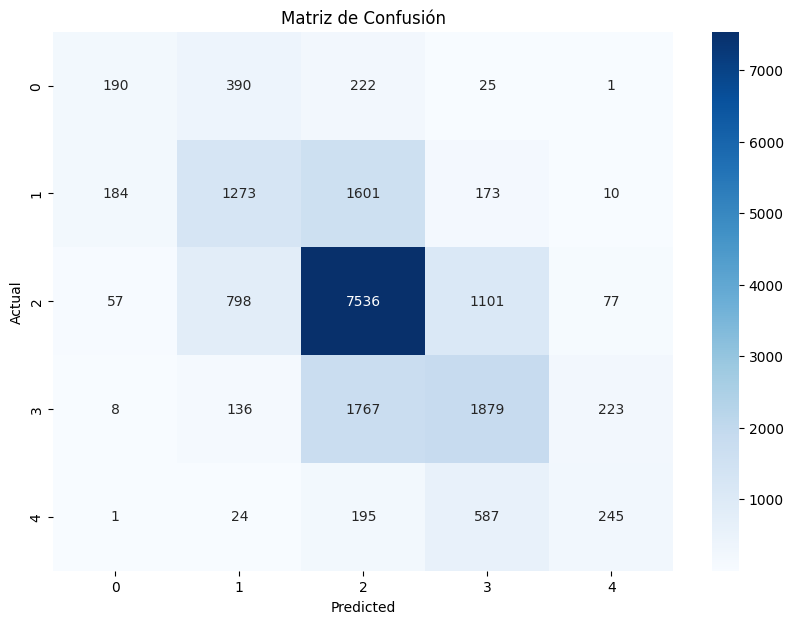

In [138]:
cm = confusion_matrix(y_eval, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [139]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.43      0.23      0.30       828
           1       0.49      0.39      0.43      3241
           2       0.67      0.79      0.72      9569
           3       0.50      0.47      0.48      4013
           4       0.44      0.23      0.30      1052

    accuracy                           0.59     18703
   macro avg       0.50      0.42      0.45     18703
weighted avg       0.58      0.59      0.58     18703



### Caso 5:
El ajuste de BoW se realiza con las tecnicas:
- Case folding
- remove stop words
- stemming
- lemmatization
- remove special characters and numbers

In [140]:
train_df['phrase_processed5'] = train_df['Phrase'].apply(preprocess_text5)

reviews_train = ' '.join(train_df['phrase_processed5'])
token_pp_sequence= reviews_train.split()
vocab_pp_word = sorted(set(sorted(token_pp_sequence)))

total_tokens['pp5'] = len(token_pp_sequence)
vocab_sizes['pp5'] = len(vocab_pp_word)

print(f"total_tokens= {total_tokens['pp5']},", f"vocab_sizes= {vocab_sizes['pp5']}")

total_tokens= 367998, vocab_sizes= 11622


In [141]:
del df, corpus, X_train, X_eval, y_train, y_eval

gc.collect()

7097

In [142]:
corpus = []
for i, sent in enumerate(train_df['phrase_processed5']):
  conteo = Counter(sent.split())
  for clave in conteo:
    conteo[clave] = 1
  corpus.append(conteo)

df = pd.DataFrame(corpus).fillna(0).astype(int)

df = df.reindex(sorted(df.columns), axis=1)
df.head()

,aaa,aaliyah,aan,abagnal,abandon,abbass,abbott,abbrevi,abc,abderrahman,...,ziyi,zoe,zombi,zombieland,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 11622) (74810,)
shape: (18703, 11622) (18703,)


In [144]:
mnb_pp5= MultinomialNB()

start_time = time.time()
mnb_pp5.fit(X_train, y_train)
end_time = time.time()
models_time['pp5'] = end_time - start_time

In [145]:
y_pred = mnb_pp5.predict(X_eval)

models_acuracy['pp5']=accuracy_score(y_eval, y_pred)
models_f1score['pp5']=f1_score(y_eval, y_pred, average='weighted')
print("Precisión en el conjunto de prueba:", models_acuracy['pp5'])
print("F1-Score (weighted):", models_f1score['pp5'])

Precisión en el conjunto de prueba: 0.59348767577394
F1-Score (weighted): 0.5762634543408777


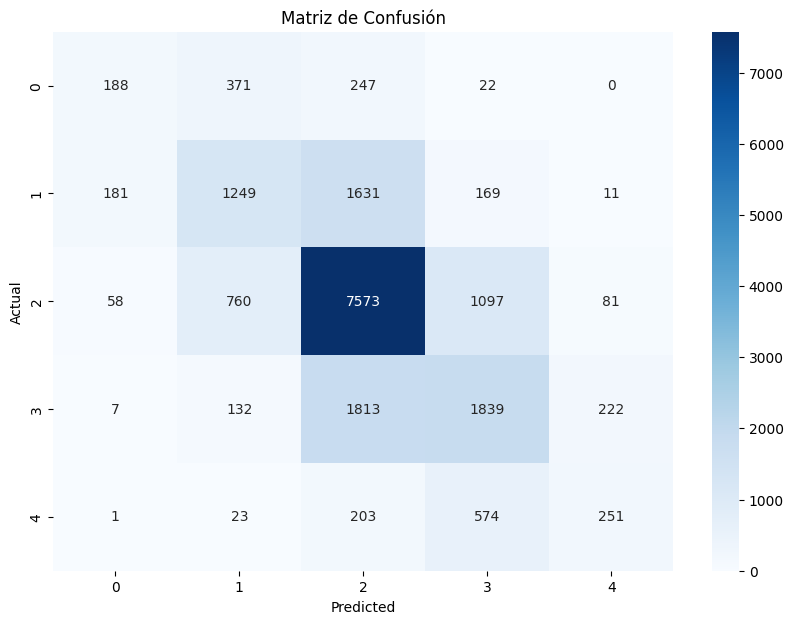

In [146]:
cm = confusion_matrix(y_eval, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [147]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.43      0.23      0.30       828
           1       0.49      0.39      0.43      3241
           2       0.66      0.79      0.72      9569
           3       0.50      0.46      0.48      4013
           4       0.44      0.24      0.31      1052

    accuracy                           0.59     18703
   macro avg       0.51      0.42      0.45     18703
weighted avg       0.57      0.59      0.58     18703



### Caso 6:
El ajuste de BoW se realiza con las tecnicas:
- Case folding
- remove stop words
- stemming
- lemmatization
- remove special characters and numbers
- instead of using a 0/1 (binary) vector, use the number of times that a word occurs in the text

In [148]:
total_tokens['pp6'] = total_tokens['pp5']
vocab_sizes['pp6'] = vocab_sizes['pp5']

print(f"total_tokens= {total_tokens['pp6']},", f"vocab_sizes= {vocab_sizes['pp6']}")

total_tokens= 367998, vocab_sizes= 11622


In [149]:
del df, corpus, X_train, X_eval, y_train, y_eval

gc.collect()

7106

In [150]:
corpus = []
for i, sent in enumerate(train_df['phrase_processed5']):
  corpus.append(Counter(sent.split()))

df = pd.DataFrame(corpus).fillna(0).astype(int)

df = df.reindex(sorted(df.columns), axis=1)
df.head()

,aaa,aaliyah,aan,abagnal,abandon,abbass,abbott,abbrevi,abc,abderrahman,...,ziyi,zoe,zombi,zombieland,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
X_train, X_eval, y_train, y_eval = train_test_split(
    df, train_df['Sentiment'], test_size=0.2, random_state=42
)
print('shape:', X_train.shape, y_train.shape)
print('shape:', X_eval.shape, y_eval.shape)

shape: (74810, 11622) (74810,)
shape: (18703, 11622) (18703,)


In [152]:
mnb_pp6= MultinomialNB()

start_time = time.time()
mnb_pp6.fit(X_train, y_train)
end_time = time.time()
models_time['pp6'] = end_time - start_time

In [153]:
y_pred = mnb_pp6.predict(X_eval)

models_acuracy['pp6']=accuracy_score(y_eval, y_pred)
models_f1score['pp6']=f1_score(y_eval, y_pred, average='weighted')
print("Precisión en el conjunto de prueba:", models_acuracy['pp6'])
print("F1-Score (weighted):", models_f1score['pp6'])

Precisión en el conjunto de prueba: 0.5930064695503395
F1-Score (weighted): 0.5757746201608549


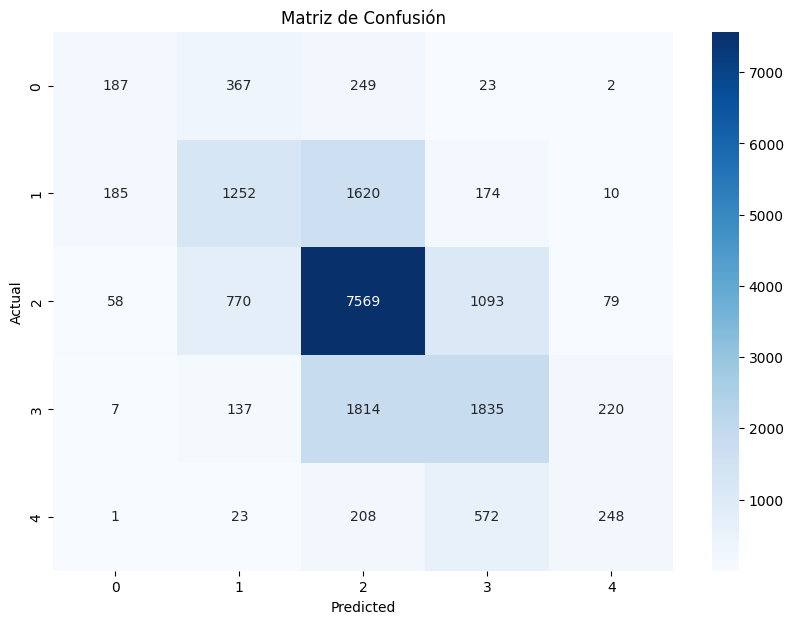

In [154]:
cm = confusion_matrix(y_eval, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [155]:
report = classification_report(y_eval, y_pred)
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.43      0.23      0.30       828
           1       0.49      0.39      0.43      3241
           2       0.66      0.79      0.72      9569
           3       0.50      0.46      0.48      4013
           4       0.44      0.24      0.31      1052

    accuracy                           0.59     18703
   macro avg       0.50      0.42      0.45     18703
weighted avg       0.57      0.59      0.58     18703



## Conclusiones:

In [156]:
results = pd.DataFrame([total_tokens
                        ,vocab_sizes
                        ,models_time
                        ,models_acuracy
                        ,models_f1score]).T

results.columns = ['total_tokens', 'vocab_sizes', 'training_time', 'accuracy', 'f1_score']
results.index = ['caso_0', 'caso_1', 'caso_2', 'caso_3', 'caso_4', 'caso_5','caso_6']

In [157]:
results

,total_tokens,vocab_sizes,training_time,accuracy,f1_score
caso_0,676776.0,18087.0,16.007943,0.594236,0.585323
caso_1,677364.0,16465.0,17.848892,0.594236,0.584347
caso_2,428043.0,16334.0,18.545607,0.591563,0.579889
caso_3,428043.0,11973.0,13.133028,0.594824,0.578652
caso_4,428043.0,11953.0,11.305312,0.594717,0.578476
caso_5,367998.0,11622.0,10.973437,0.593488,0.576263
caso_6,367998.0,11622.0,13.390586,0.593006,0.575775


Se aplican acumulativamente las técnicas de preprocesamiento para texto:

- Case folding
- remove stop words
- stemming
- lemmatization
- remove special characters and numbers
- instead of using a 0/1 (binary) vector, use the number of times that a word occurs in the text

Cada preprocesamiento reduce la cantidad de variables predictoras de nuestro modelo, pasando de un BoW completo de 18087, a 16465 gracias Case Folding (caso 1), 11622 para el caso 5 (case folding, stop word removing, stemming, lemmatization, numbers and special characters remove). El caso 6 (caso 5 pero en lugar de variables 1/0 se incluye el conteo de ocurrencia) presenta la misma cantidad de variables predictoras que el caso 5. Gracias a esta constante reducción en la dimensionalidad del problema de clasificación se observa una constante reducción en el tiempo de entrenamiento.

Se utilizan las metodologías de preprocesamiento de texto por defecto de la famosa librería `NLTK`, un análisis más exhaustivo de diferentes versiones de este preprocesamiento y calibración de sus hyperparámetros es recomendado para futuras investigaciones.

Con respecto a las metricas del accuracy y f1-score se observa una ligera reducción a medida que se implementa cada regla de procesamiento de texto. Estas diferencias podrían no ser estadísticamente significativas al momento de aplicar k-fold cross-validation. En el caso de ser diferencias significativas, se debería analizar la posibilidad de cambio de versión o hyperparámetros de la respectiva técnica.

Una metrica alta del modelo en el analsis de sentimientos no era objetivo de este estudio, sin embargo, mediante un modelo simple se puede obtener un accuracy de 0.59, un valor considerablemente alto al compararse con el campeón de Kaggle (0.76). Se considera valioso la visualización del preprocesamiento de texto sobre la eficiencia y métricas del modelo.